# Openclassrooms training PJ7 part 3 : automatic image indexing
# Usage of CNN with transfer learning - same 20 dog breeds as part 2 (that was with SIFT)

In [1]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions_py import * # MODIFIED for kaggle (replaced by functions_py instead of functions)
importlib.reload(sys.modules['functions_py']) # MODIFIED for kaggle

#from display_factorial import *
#importlib.reload(sys.modules['display_factorial'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np    

import ipywidgets as widgets

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

#from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_auc_score

import codecs


DATA_PATH = os.path.join("../input", "stanford-dogs-dataset", "images") # Modified for kaggle
DATA_PATH = os.path.join(DATA_PATH, "Images")


DATA_PATH_FILE = os.path.join(DATA_PATH, "*.csv")
ALL_FILES_LIST = glob.glob(DATA_PATH_FILE)

ALL_FEATURES = []

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
from seaborn import boxplot
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


### For progress bar :
#from tqdm import tqdm_notebook as tqdm  #Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
from tqdm.notebook import tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

In [2]:
from sklearn import preprocessing

In [3]:
from PIL import Image
from io import BytesIO

In [4]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

from keras.applications.vgg16 import decode_predictions

In [5]:
#from keras.preprocessing.image import ImageDataGenerator

In [6]:
import keras

In [7]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [8]:
# Those variables must be consisten with what first notebook has been ran with
NB_CLASSES = 20
NB_DOGS_PER_RACE = 100 # 100. Note: we have 120 dog races in the dataset

# Load pictures and labels

In [9]:
with open('../input/openclassrooms-pj7-modelisation/filenamesmodel1.pickle', 'rb') as f:
    filename_images = pickle.load(f)

In [10]:
len(filename_images)

2000

In [11]:
image_labels = [filename_image.split('/')[5].split('-')[1] for filename_image in filename_images]

In [12]:
labelencoder = preprocessing.LabelBinarizer()
image_labels_numeric = labelencoder.fit_transform(image_labels)

In [13]:
image_labels_numeric = np.array(image_labels_numeric)

In [14]:
#np_pics = np.array([np.array(Image.open(fname)) for fname in filename_images])

In [15]:
images_list = []

for fname in filename_images:
    img = load_img(fname, target_size=(224, 224))
    img = img_to_array(img) 
    img = preprocess_input(img) 
    #preprocess_input subtracts the mean RGB channels of the imagenet dataset. This is because the model we are using has been trained on a different dataset
    images_list.append(img)

images_list = np.array(images_list)
images_list.shape

(2000, 224, 224, 3)

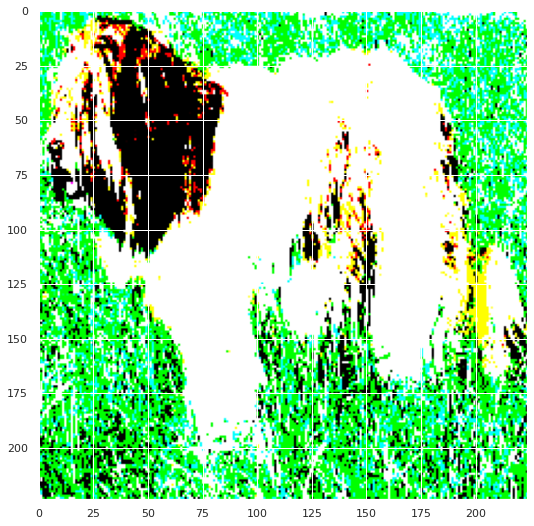

In [16]:
plt.imshow(images_list[0])

# Split train / test

In [17]:
images_train, images_test, images_train_labels, images_test_labels = train_test_split(images_list, image_labels_numeric, test_size=0.1, random_state=42, shuffle = True, stratify = image_labels)

In [18]:

# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = Flatten()(model.output)
#x = model.output # Code from OC training (there was no flatten, didn't work : ValueError: Shapes (None, 20) and (None, 7, 7, 20) are incompatible)

# Ajouter la nouvelle couche fully-connected pour la classification à NB_CLASSES classes
predictions = Dense(NB_CLASSES, activation='softmax')(x)

# Définir le nouveau modèle
new_model = keras.Model(inputs=model.input, outputs=predictions)

58892288/58889256 [==============================] - 0s 0us/step


In [19]:
# Ne pas entraîner les 5 premières couches (les plus basses) 
for layer in model.layers[:5]:
   layer.trainable = False

In [20]:
# Compiler le modèle 
new_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [21]:
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [22]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = new_model.fit(images_train, images_train_labels, validation_split=0.20, epochs=50, batch_size=64, verbose=2)

Epoch 1/50
23/23 - 9s - loss: 6.5878 - accuracy: 0.0597 - val_loss: 2.9902 - val_accuracy: 0.0667
Epoch 2/50
23/23 - 7s - loss: 2.9760 - accuracy: 0.0632 - val_loss: 2.9722 - val_accuracy: 0.0694
Epoch 3/50
23/23 - 7s - loss: 2.9092 - accuracy: 0.1111 - val_loss: 2.8976 - val_accuracy: 0.1139
Epoch 4/50
23/23 - 7s - loss: 2.7961 - accuracy: 0.1500 - val_loss: 2.7880 - val_accuracy: 0.1389
Epoch 5/50
23/23 - 7s - loss: 2.6638 - accuracy: 0.1875 - val_loss: 2.7027 - val_accuracy: 0.1667
Epoch 6/50
23/23 - 7s - loss: 2.5249 - accuracy: 0.2215 - val_loss: 2.7787 - val_accuracy: 0.1556
Epoch 7/50
23/23 - 7s - loss: 2.4047 - accuracy: 0.2660 - val_loss: 2.6687 - val_accuracy: 0.2250
Epoch 8/50
23/23 - 7s - loss: 2.3231 - accuracy: 0.2944 - val_loss: 2.4811 - val_accuracy: 0.2667
Epoch 9/50
23/23 - 7s - loss: 2.1743 - accuracy: 0.3382 - val_loss: 2.4526 - val_accuracy: 0.2556
Epoch 10/50
23/23 - 7s - loss: 2.0778 - accuracy: 0.3667 - val_loss: 2.3715 - val_accuracy: 0.2889
Epoch 11/50
23/23 -

In [23]:
loss, acc = new_model.evaluate(images_test, images_test_labels,verbose=0)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

loss on the test set is 5.62
accuracy on the test set is 0.295


In [24]:
predictions_test = new_model.predict(images_test)
images_test_labels_text = labelencoder.inverse_transform(images_test_labels)
predictions_test_labels_text = labelencoder.inverse_transform(predictions_test)

In [25]:
precision_score(images_test_labels_text, predictions_test_labels_text, average='micro')

0.295

In [26]:
recall_score(images_test_labels_text, predictions_test_labels_text, average='micro')

0.295

# Error analysis

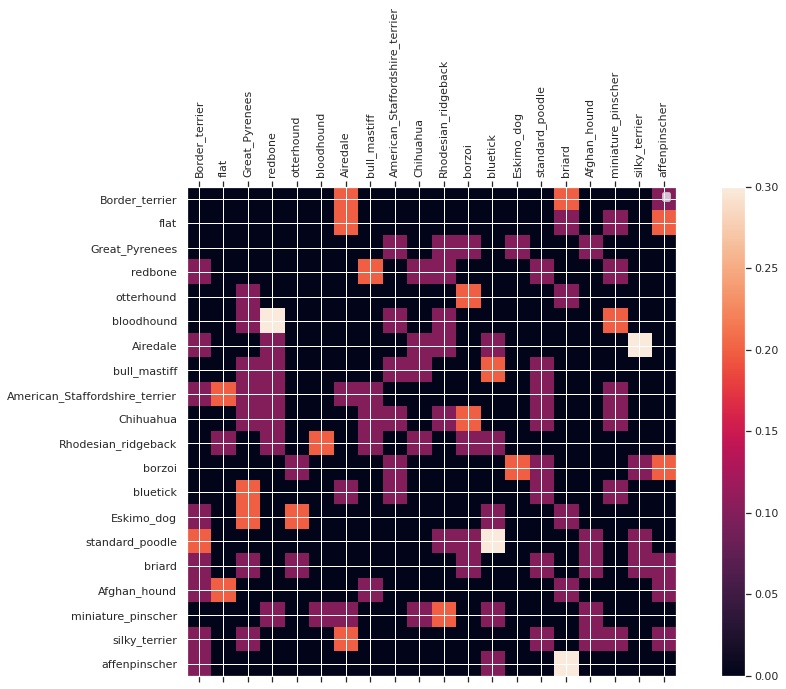

In [27]:
confusion_mx = confusion_matrix(images_test_labels_text, predictions_test_labels_text, labels=list(set(images_test_labels_text)))


row_sums = confusion_mx.sum(axis=1, keepdims=True)
norm_confusion_mx = confusion_mx / row_sums



np.fill_diagonal(norm_confusion_mx, 0)

figure = plt.figure() 
axes = figure.add_subplot(111) 
caxes = axes.matshow(norm_confusion_mx)
figure.colorbar(caxes)

plt.xticks(rotation=90) 
plt.yticks(rotation=0) 

plt.xticks(np.arange(20), list(set(images_test_labels_text)))
plt.yticks(np.arange(20), list(set(images_test_labels_text)))
plt.legend()

Text(0.5, 1.0, 'Top misclassed pairs (actual / predicted)')

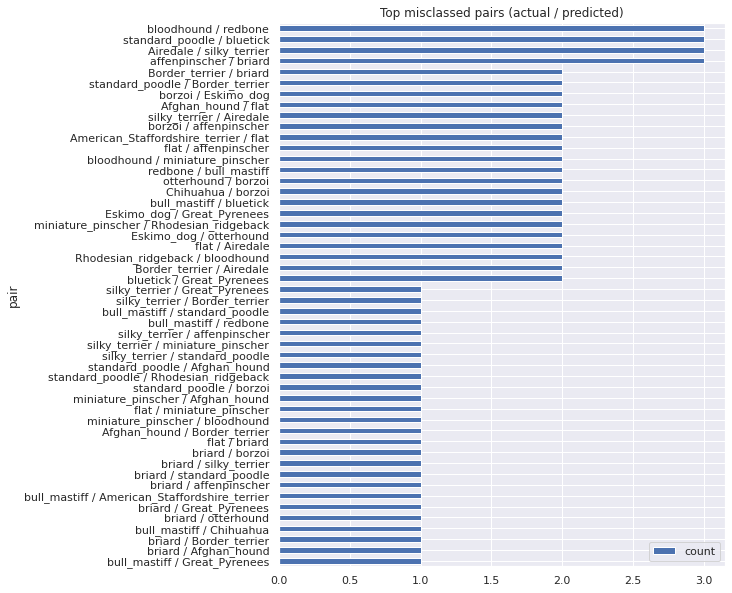

In [28]:
df_predictions_compare = pd.DataFrame({'actual': images_test_labels_text, 'pred': predictions_test_labels_text})
df_predictions_compare['count'] = 1


misclass_df = df_predictions_compare[df_predictions_compare['actual'] != df_predictions_compare['pred']].groupby(['actual', 'pred']).sum().sort_values(['count'], ascending=False).reset_index()
misclass_df['pair'] = misclass_df['actual'] + ' / ' + misclass_df['pred']
misclass_df = misclass_df[['pair', 'count']].take(range(50))
misclass_df.sort_values(['count']).plot.barh(figsize=(8, 10), x='pair')
plt.title('Top misclassed pairs (actual / predicted)')

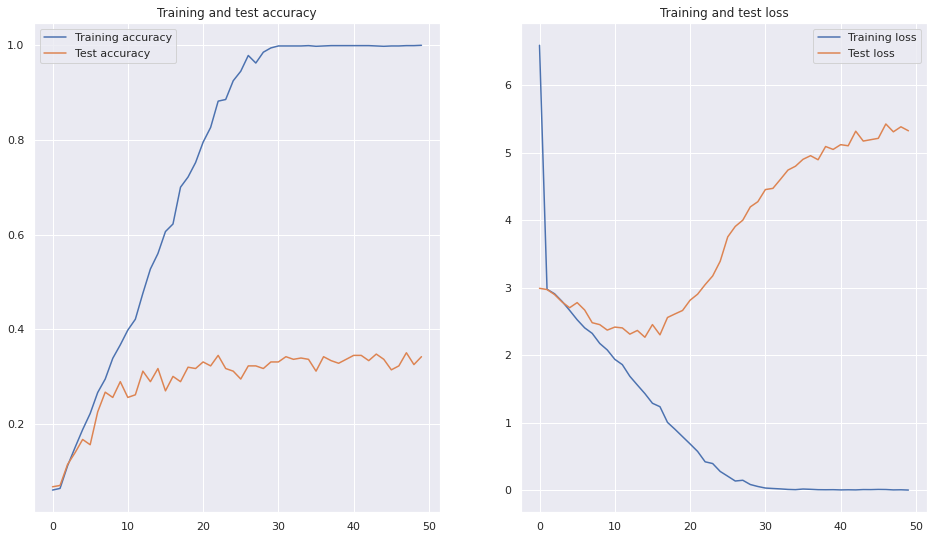

In [29]:
plt.subplot(1, 2, 1)
plt.title('Training and test accuracy')
plt.plot(model_info.epoch, model_info.history['accuracy'], label='Training accuracy')
plt.plot(model_info.epoch, model_info.history['val_accuracy'], label='Test accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and test loss')
plt.plot(model_info.epoch, model_info.history['loss'], label='Training loss')
plt.plot(model_info.epoch, model_info.history['val_loss'], label='Test loss')
plt.legend()

plt.show()



In [30]:
images_test_labels_text
predictions_test_labels_text

array(['standard_poodle', 'bluetick', 'bluetick', 'bluetick', 'briard',
       'briard', 'silky_terrier', 'affenpinscher', 'flat', 'bluetick',
       'American_Staffordshire_terrier', 'briard', 'redbone', 'redbone',
       'briard', 'Border_terrier', 'silky_terrier', 'flat', 'bluetick',
       'flat', 'bluetick', 'Border_terrier', 'Afghan_hound',
       'Great_Pyrenees', 'otterhound', 'American_Staffordshire_terrier',
       'flat', 'Rhodesian_ridgeback', 'Airedale', 'Border_terrier',
       'otterhound', 'flat', 'bluetick', 'borzoi', 'Eskimo_dog',
       'affenpinscher', 'Border_terrier',
       'American_Staffordshire_terrier', 'silky_terrier', 'borzoi',
       'bluetick', 'affenpinscher', 'Border_terrier', 'otterhound',
       'Airedale', 'briard', 'flat', 'Airedale',
       'American_Staffordshire_terrier', 'bull_mastiff', 'silky_terrier',
       'standard_poodle', 'miniature_pinscher', 'bull_mastiff',
       'affenpinscher', 'Great_Pyrenees', 'Airedale', 'briard',
       'Eskimo_d

In [31]:
misclassed_pairs_array = misclass_df['pair'].str.split('/')

In [32]:
import matplotlib.image as mpimg
#plt.imshow(mpimg.imread('MyImage.png'))

# Show samples from most misclassed breeds

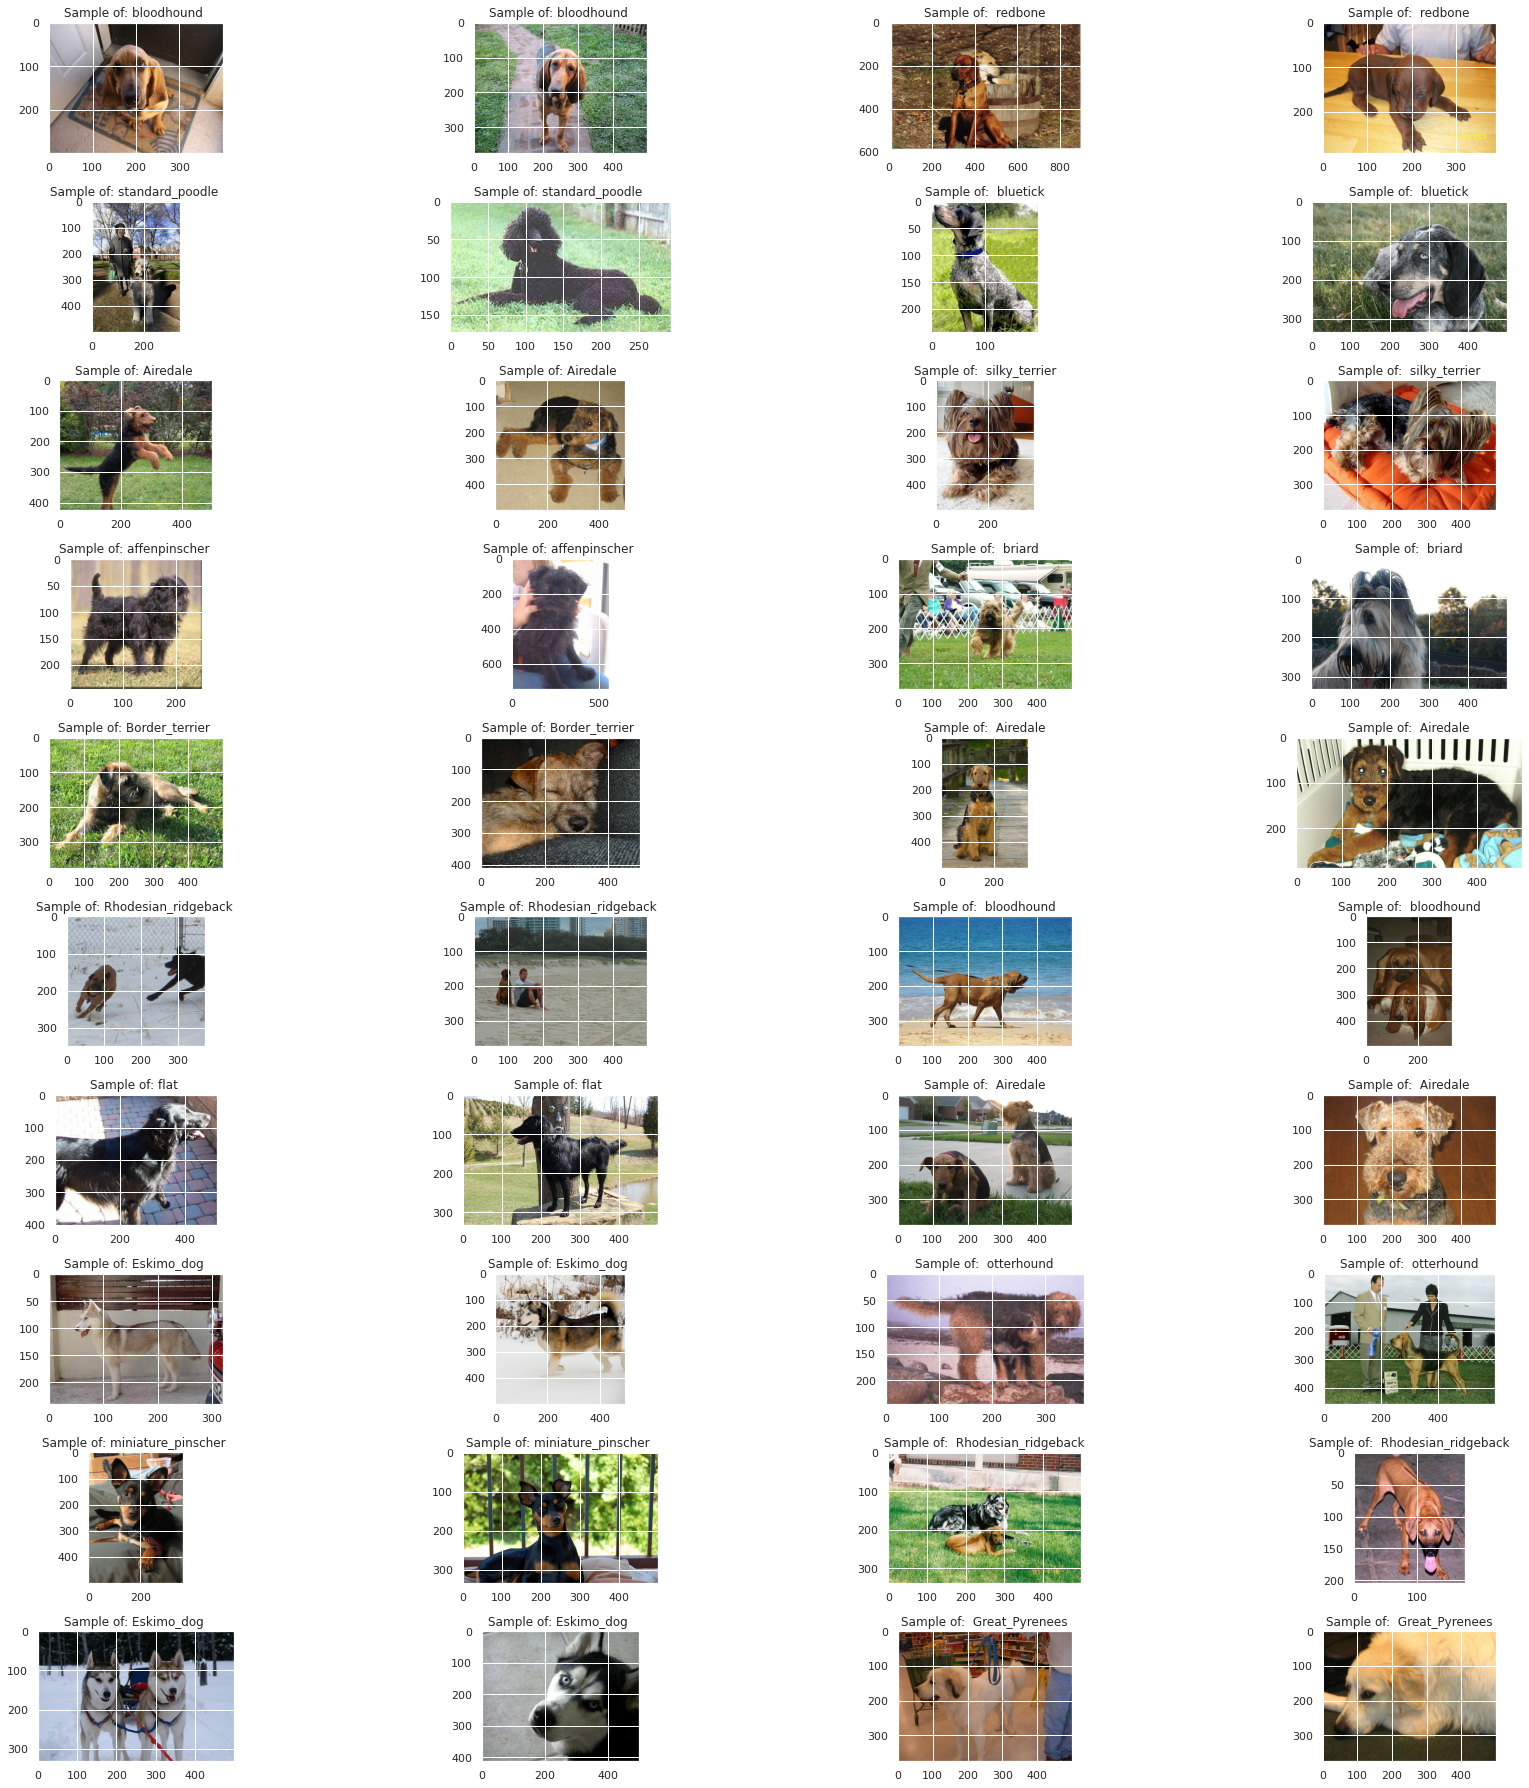

In [33]:
rows = 10
cols = 4
size = 25

misclassed_indice = 0

fig,ax=plt.subplots(rows,cols)
fig.set_size_inches(size,size)

i = 0
j = 0
plt.rcParams["axes.grid"] = False
for misclassed_pair in misclassed_pairs_array:
    if (i < rows):
        actual_indices = [ind for ind,x in enumerate(image_labels) if x == misclassed_pair[0].strip()] 
        predicted_indices = [ind for ind,x in enumerate(image_labels) if x == misclassed_pair[1].strip()] 

        misclassed_pair0 = misclassed_pair[0]
        misclassed_pair1 = misclassed_pair[1]

        rand_indices_actual = np.random.default_rng().choice(len(actual_indices), size=2, replace=False)
        rand_indices_predicted = np.random.default_rng().choice(len(predicted_indices), size=2, replace=False)
        
        plt.grid(None)
        ax[i,0].imshow(mpimg.imread(filename_images[actual_indices[rand_indices_actual[0]]]))
        plt.grid(None)
        ax[i,1].imshow(mpimg.imread(filename_images[actual_indices[rand_indices_actual[1]]]))
        plt.grid(None)
        ax[i,2].imshow(mpimg.imread(filename_images[predicted_indices[rand_indices_predicted[0]]]))
        plt.grid(None)
        ax[i,3].imshow(mpimg.imread(filename_images[predicted_indices[rand_indices_predicted[1]]]))
        plt.grid(None)


        ax[i,0].set_title(f'Sample of: {misclassed_pair0}')
        ax[i,1].set_title(f'Sample of: {misclassed_pair0}')
        ax[i,2].set_title(f'Sample of: {misclassed_pair1}')
        ax[i,3].set_title(f'Sample of: {misclassed_pair1}')

        i += 1
        misclassed_indice += 1
        
plt.tight_layout()